# Computational-based 


In [31]:
# Load the Data

import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


# clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)

clean_data.info()
clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 5072
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  1114 non-null   int64 
 1   Text                1114 non-null   object
 2   Subjectivity        1114 non-null   int64 
 3   Sentiment Polarity  1114 non-null   object
 4   Emotion             1114 non-null   object
 5   Sarcasm             1114 non-null   int64 
 6   Irony               1114 non-null   int64 
 7   Negation            1114 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 78.3+ KB


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
5068,20200659,"Wow growing together, so I will get a 17 black...",1,positive,disgust,0,1,0
5069,20200660,Equal pay for equal work to be introduced in t...,1,positive,anticipation,0,0,1
5070,20200661,No cash when worth more then 10000?. Use offsh...,1,negative,anticipation,0,1,0
5071,20200662,"Budget 2020 reactions: Some say it’s good, oth...",1,negative,anger,0,0,0
5072,20200663,"Budget 2020 reactions: Some say it’s good, oth...",1,neutral,sadness,0,0,0


In [32]:
# Handle text processing and tokenisation:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer, AutoTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokenizer.model_max_length = 100
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, ci, ##gare, ##tte, touch...","[101, 11838, 21455, 12818, 11200, 46511, 11993...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, sc, ##anne, ##d, budget, throughout,...","[101, 56938, 16427, 31570, 10163, 21455, 15410...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ces, ##sation, program, peo...","[101, 18874, 67503, 12139, 22337, 11660, 11227...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 31329, 26150, 13742, 23247, 47651, 22389...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 37872, 16497, 12047, 10228, 11913, 54838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [33]:
# Count Punctuation

import re
import pandas as pd

def count_punctuation(text, tokens):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    token_count = len(tokens)
    if token_count == 0:
        token_count = 1
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count,
        'exclamation_score': exclamation_count / token_count,
        'question_score': question_count / token_count,
        'ellipsis_score': ellipsis_count / token_count,
        'comma_score': comma_count / token_count,
        'period_score': period_count / token_count
    })

processed_data = processed_data.join(
    processed_data.apply(lambda row: count_punctuation(row['Raw_Text'], row['tokens']), axis=1)
)
    
print(processed_data)

            ID                                               Text  \
0     20180001  great budget even cigarette touched great work...   
1     20180002  exactly scanned budget throughout earth make i...   
2     20180003  already smoking cessation program people want ...   
3     20180004  alcohol fuel private vehicle raising tax cigar...   
4     20180005  practical say third world country supposed eur...   
...        ...                                                ...   
5068  20200659              wow growing together get black budget   
5069  20200660  equal pay equal work introduced private sector...   
5070  20200661                    cash worth use offshore account   
5071  20200662  budget reaction say good others say bad earnes...   
5072  20200663  budget reaction say good others say bad happen...   

      Subjectivity Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0                1           positive         trust        0      0         1   
1        

In [34]:
#getting Polarity. 
from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification

# Load sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def get_sentiment(tokens):
    total_score = 0
    result = sentiment_analyzer(tokens)
    if len(result) == 0:
        return 0.0
    for r in result:
        total_score += r['score']
    return total_score / len(result)

processed_data['polarity_score'] = processed_data['tokens'].apply(get_sentiment)

print(processed_data[['Text','Sentiment Polarity','polarity_score']].head())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
#Subjectivity

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
import torch
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
bert_model = BertModel.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and convert to BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X = get_bert_embeddings(processed_data['Text'])
y = processed_data['Subjectivity']

# Train SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
clf.fit(X, y)

# Get the decision function values or probabilities
subjectivity_probabilities = clf.predict_proba(X)

# Assuming binary classification, we take the probability of the positive class (index 1)
processed_data['subjectivity_score'] = subjectivity_probabilities[:, 1]

print(processed_data[['Text', 'Subjectivity', 'subjectivity_score']].head())
print(processed_data[['Text', 'Subjectivity', 'subjectivity_score']].tail())

# subjectivity_scores = clf.decision_function(X)
# processed_data['subjectivity_score'] = subjectivity_scores
# print(processed_data[['Text', 'Subjectivity', 'subjectivity_score']].head())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

   Subjectivity Score  
0            0.995163  
1            0.999986  
2            0.999996  
3            0.999991  
4            0.997121  
                                                   Text  Subjectivity  \
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1 

In [ ]:
# Sarcasm detection using BERT and LSTM
import torch
import torch.nn as nn


class SarcasmLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_layers):
        super(SarcasmLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        logits = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(logits)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
bert_model = BertModel.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM model
sarcasm_model = SarcasmLSTM(bert_model, hidden_dim=256, output_dim=1, num_layers=2)

# Tokenize and predict sarcasm for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sarcasm_prob = sarcasm_model(inputs).numpy()

processed_data['sarcasm_score'] = sarcasm_prob.flatten()  # Keep the raw probability

print(processed_data[['Text', 'Sarcasm', 'sarcasm_score']].head())

                                                Text  Sarcasm  Sarcasm Score
0  great budget even cigarette touched great work...        0       0.487626
1  exactly scanned budget throughout earth make i...        0       0.491795
2  already smoking cessation program people want ...        0       0.490174
3  alcohol fuel private vehicle raising tax cigar...        0       0.489962
4  practical say third world country supposed eur...        0       0.484609


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd

# Load the fine-tuned RoBERTa model and tokenizer for irony detection
tokenizer = AutoTokenizer.from_pretrained("vikram71198/roberta-base-finetuned-irony")
roberta_model = AutoModelForSequenceClassification.from_pretrained("vikram71198/roberta-base-finetuned-irony")

# Function to get predictions directly from the RoBERTa model
def detect_irony(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # The model returns a probability for each class (ironic or not ironic)
    # Assuming binary classification (ironic vs. not ironic), we take the probability for the 'ironic' class
    irony_scores = probabilities[:, 1].numpy()  # Index 1 is usually for the positive class
    
    return irony_scores

# Assume processed_data is your DataFrame containing a 'Text' column
# Get irony_scores for each text in the DataFrame
processed_data['irony_score'] = detect_irony(processed_data['Text'])

# Print the results
print(processed_data[['Text', 'irony_score']].head())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                                Text  Irony Score
0  great budget even cigarette touched great work...     0.177694
1  exactly scanned budget throughout earth make i...     0.620364
2  already smoking cessation program people want ...     0.453496
3  alcohol fuel private vehicle raising tax cigar...     0.251844
4  practical say third world country supposed eur...     0.657175


In [ ]:
# Negation detection
import torch
import torch
from TorchCRF import CRF
from transformers import AutoModelForTokenClassification


class LSTM_CRF(nn.Module):
    def __init__(self, bert_model, hidden_dim, tagset_size):
        super(LSTM_CRF, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        emissions = self.hidden2tag(lstm_output)
        return emissions

    def predict(self, inputs):
        emissions = self(inputs)
        return self.crf.decode(emissions), emissions

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("shoubhikc/negation_bert")
bert_model = BertModel.from_pretrained("shoubhikc/negation_bert")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM-CRF model
negation_model = LSTM_CRF(bert_model, hidden_dim=128, tagset_size=3)  # Assume 3 tags (e.g., "O", "NEG", "POS")

# Tokenize and predict negation for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)

negation_tags, negation_scores = negation_model.predict(inputs)

# Extract the highest score for negation tag for each sentence
processed_data['negation_score'] = [torch.max(score[:, 1]).item() for score in negation_scores]  # Assuming index 1 is the "NEG" tag

print(processed_data[['Text', 'Negation', 'negation_score']].head())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/TorchCRF/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


                                                Text  Negation  Negation Score
0  great budget even cigarette touched great work...         1        0.152457
1  exactly scanned budget throughout earth make i...         1        0.144180
2  already smoking cessation program people want ...         0        0.190720
3  alcohol fuel private vehicle raising tax cigar...         0        0.209402
4  practical say third world country supposed eur...         1        0.112441


In [ ]:
from afinn import Afinn

afinn = Afinn()
processed_data['afinn_score'] = processed_data['Raw_Text'].apply(lambda x: afinn.score(x))

#TODO : YOU FORGOT TO NORMALISE!!!!!! IDIOT

print(processed_data)

            ID                                               Text  \
0     20180001  great budget even cigarette touched great work...   
1     20180002  exactly scanned budget throughout earth make i...   
2     20180003  already smoking cessation program people want ...   
3     20180004  alcohol fuel private vehicle raising tax cigar...   
4     20180005  practical say third world country supposed eur...   
...        ...                                                ...   
5068  20200659              wow growing together get black budget   
5069  20200660  equal pay equal work introduced private sector...   
5070  20200661                    cash worth use offshore account   
5071  20200662  budget reaction say good others say bad earnes...   
5072  20200663  budget reaction say good others say bad happen...   

      Subjectivity Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0                1           positive         trust        0      0         1   
1        

# Feature distribution graphs

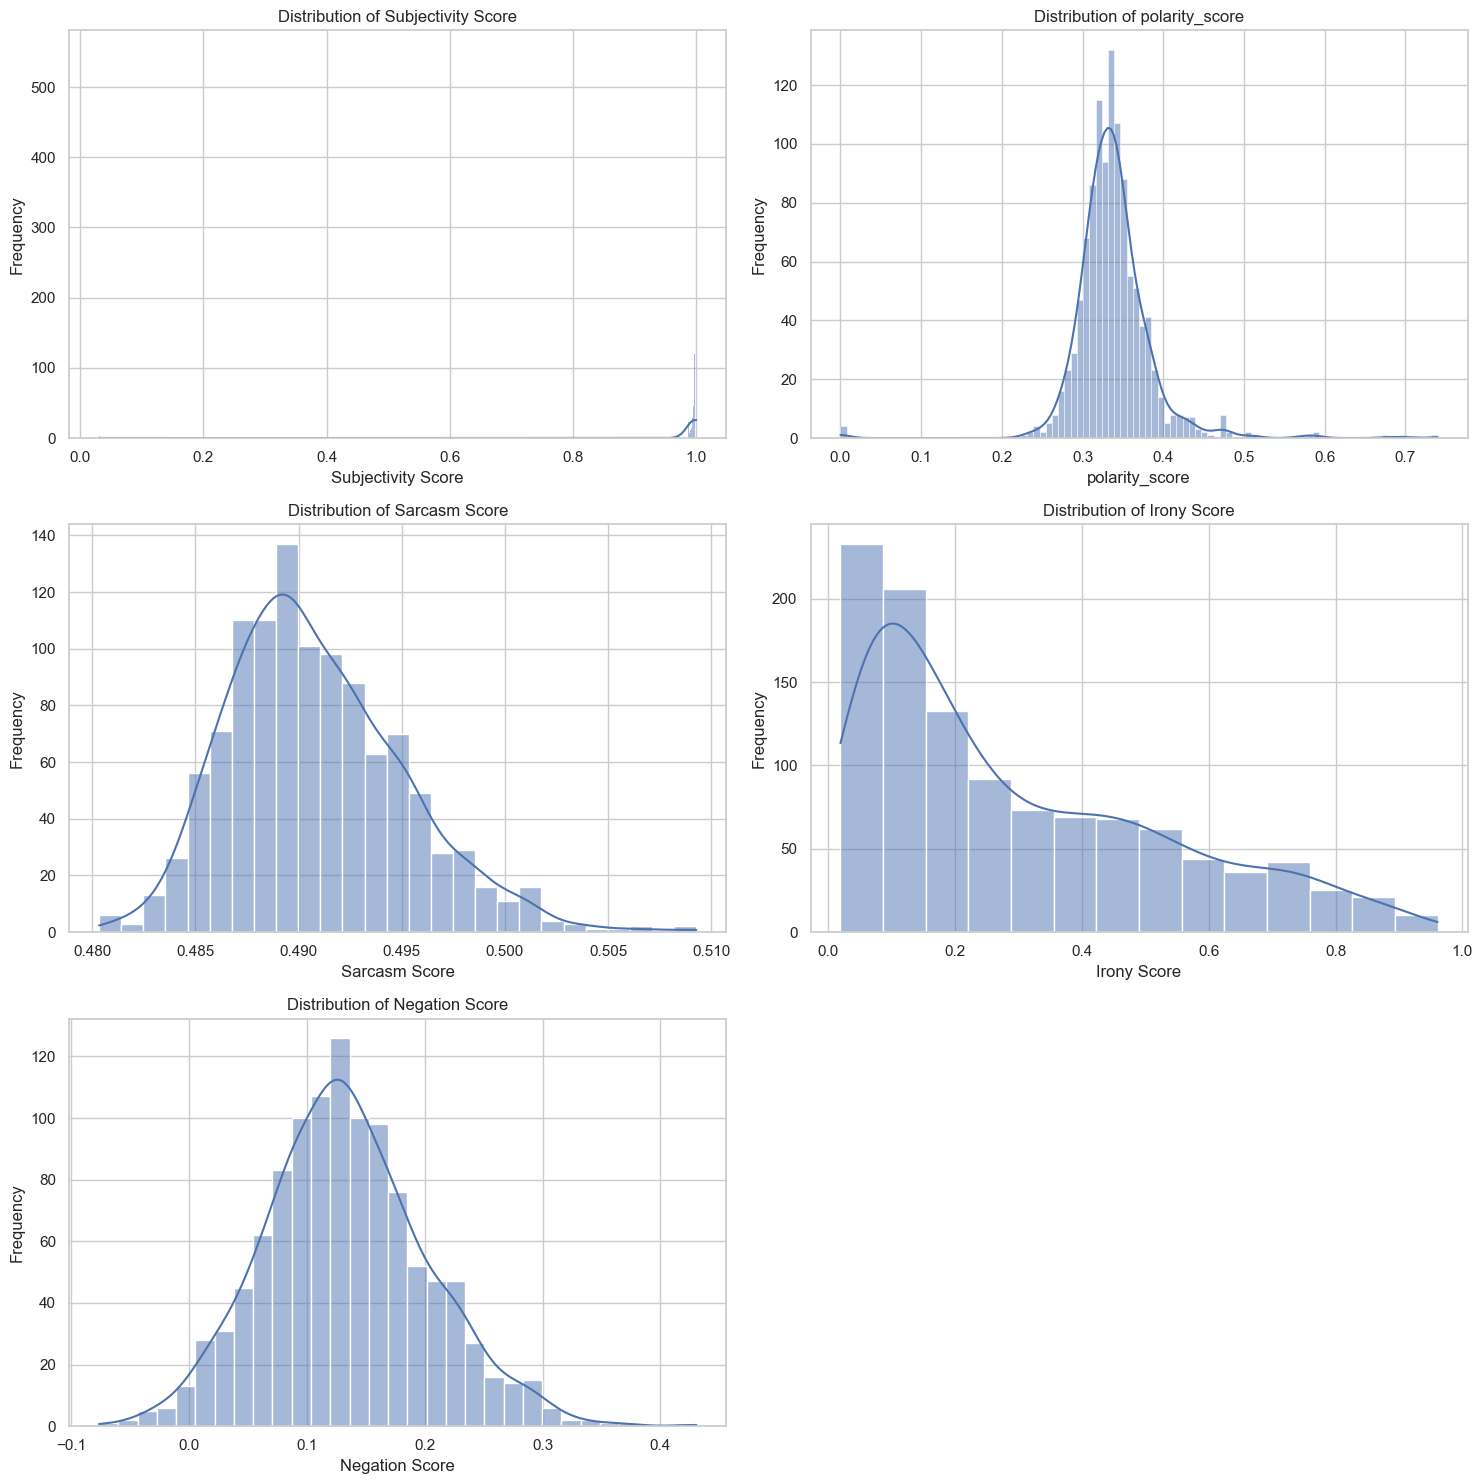

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set(style="whitegrid")

columns_to_plot = ['subjectivity_score', 'polarity_score', 'sarcasm_score', 'irony_score', 'negation_score']

# Set up the plot grid: 2 columns per row
num_cols = 2
num_rows = (len(columns_to_plot) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(processed_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots (in case of an odd number of plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show plot
plt.show()

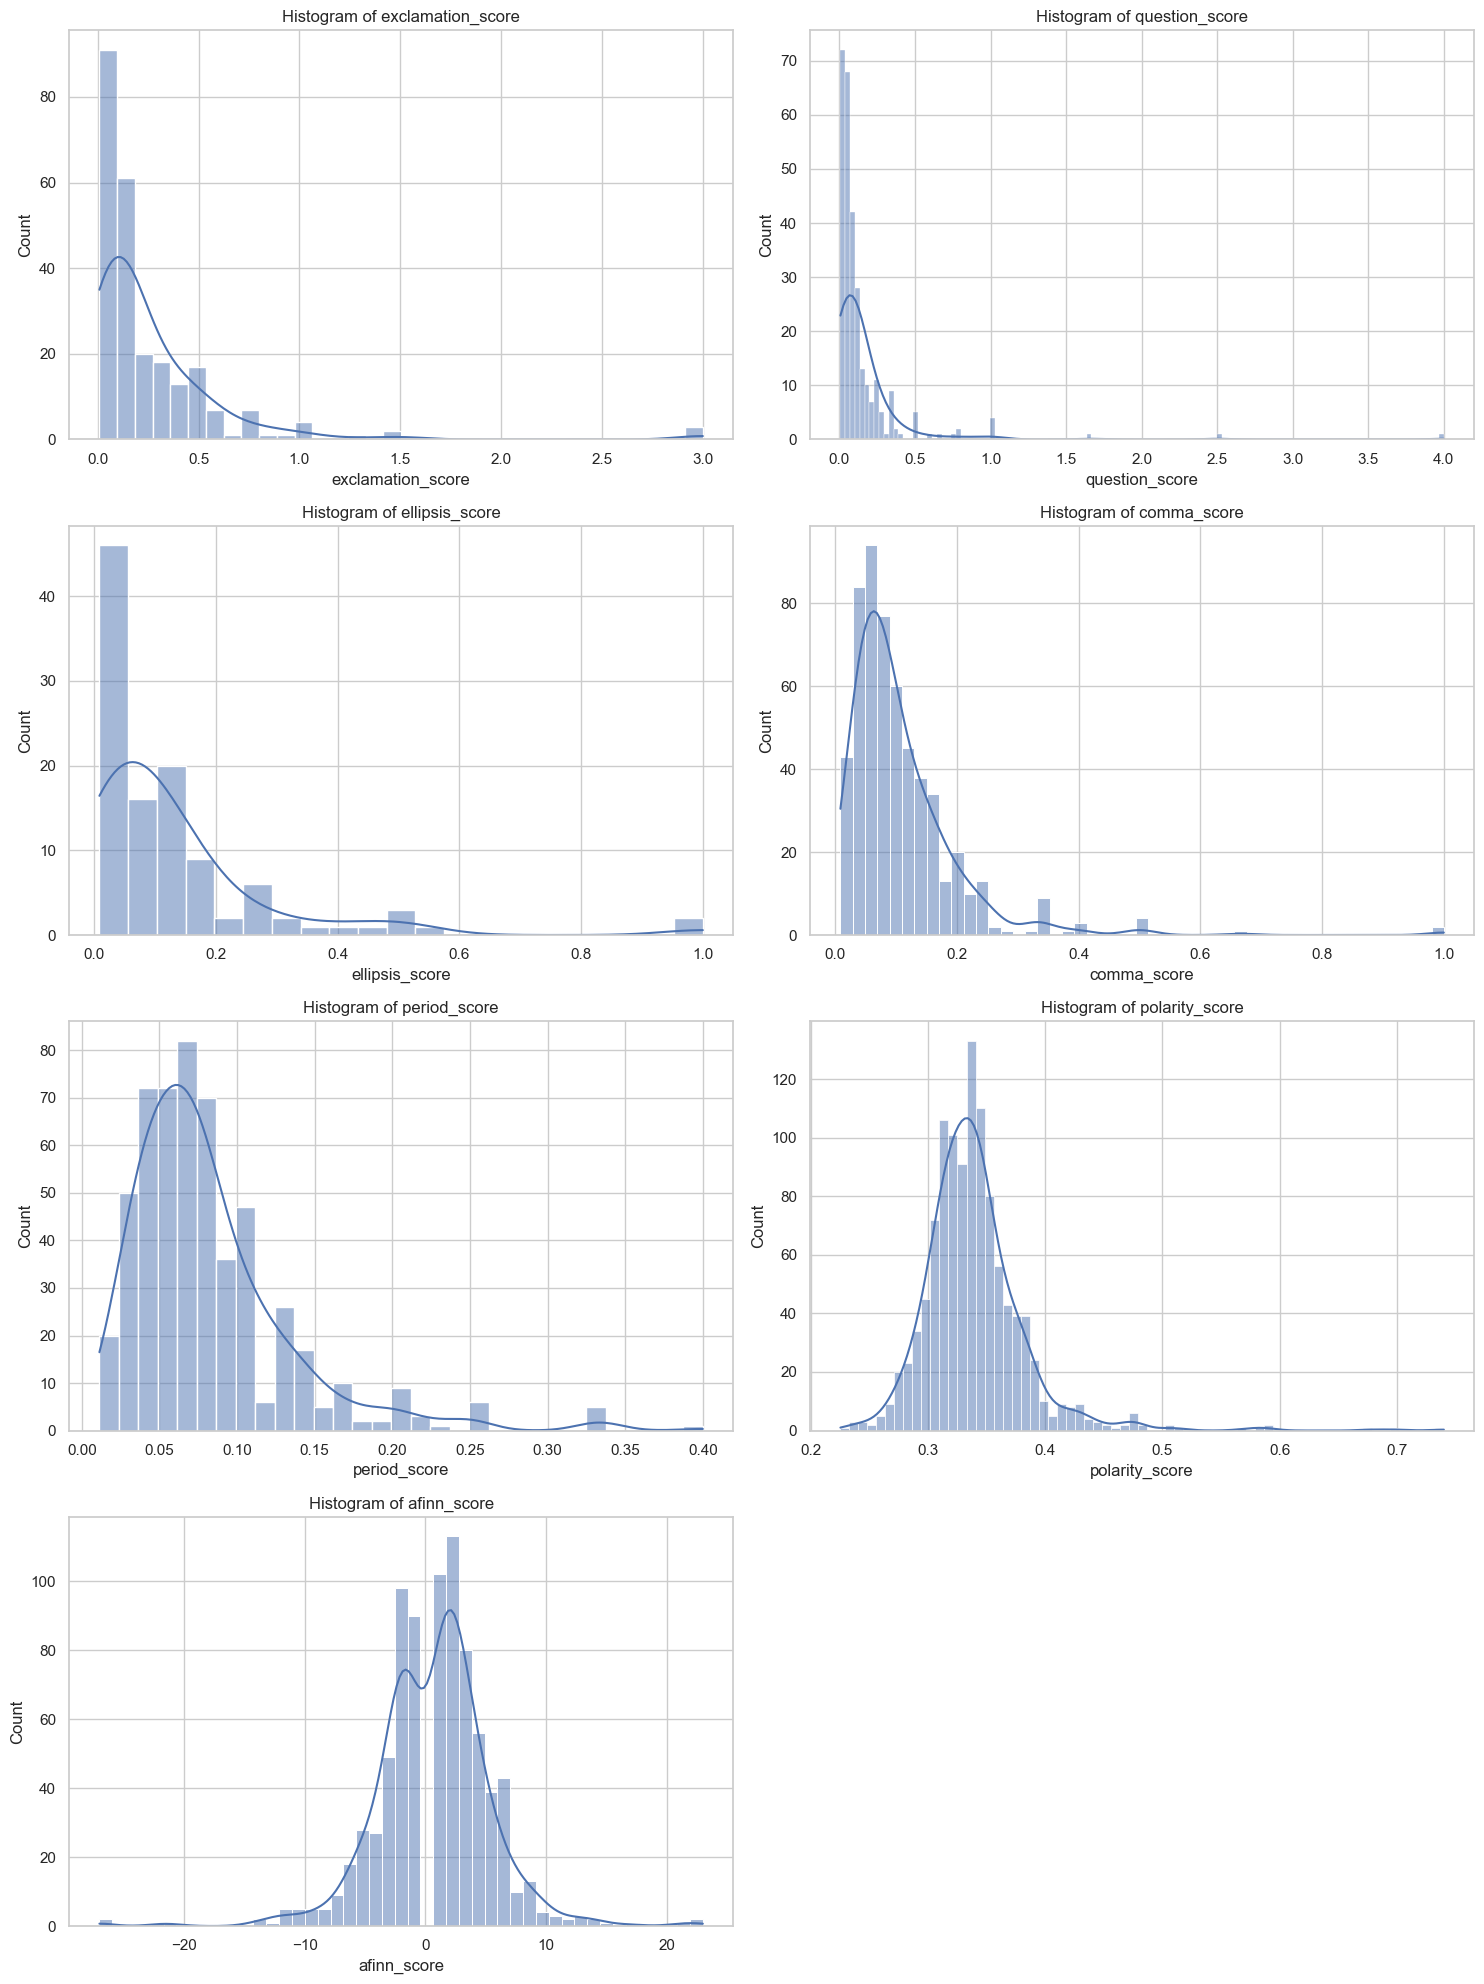

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

score_columns = [col for col in processed_data.columns if col.endswith('_score')]

# Step 2: Set up the grid layout
num_columns = 2  # Number of plots per row
num_plots = len(score_columns)
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Step 3: Plot each histogram
for i, col in enumerate(score_columns):
    row = i // num_columns
    col_index = i % num_columns
    non_zero_data = processed_data[col][processed_data[col] != 0]
    #use processed_data[col] instead of non_zero_data
    sns.histplot(non_zero_data, kde=True, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Histogram of {col}')

# If the number of plots is odd, remove the empty subplot
if num_plots % num_columns != 0:
    fig.delaxes(axes[num_rows-1, num_columns-1])

plt.tight_layout()
plt.show()

In [ ]:
processed_data.to_csv('processed_data_V2.csv', index=False)

# Feature Selection

In [ ]:
clean_data = processed_data.dropna()

to_keep = [
    'exclamation_score', 'question_score', 'ellipsis_score', 'comma_score', 'period_score',
    'Subjectivity Score', 'polarity_score',
    'afinn_score', 'negation_score', 'Sarcasm Score', 'irony_score'
]
fuzzy_data = clean_data[to_keep]
mapping_dict = {value: index for index, value in enumerate(clean_data['Emotion'].unique())}
fuzzy_data['Target'] = clean_data['Emotion'].map(mapping_dict)

# X = fuzzy_data.values    
# Y = processed_data['Emotion'].values

corr_matrix = fuzzy_data.corr()

print(corr_matrix)

                    exclamation_score  question_score  ellipsis_score  \
exclamation_score            1.000000       -0.019762       -0.026584   
question_score              -0.019762        1.000000       -0.005325   
ellipsis_score              -0.026584       -0.005325        1.000000   
comma_score                 -0.028188        0.005956       -0.063016   
period_score                -0.107931       -0.071739        0.015501   
Subjectivity Score           0.004037        0.008885       -0.000311   
polarity_score               0.219321       -0.049683       -0.112414   
afinn_score                 -0.028490       -0.009735       -0.040073   
Negation Score               0.090806       -0.022280        0.022620   
Sarcasm Score                0.150554        0.121938        0.055132   
Irony Score                  0.069500        0.022331       -0.004120   
Target                       0.113578        0.052355        0.021782   

                    comma_score  period_score  Sub

/var/folders/lx/s6mpvqt1305650xxj6d7yfj80000gn/T/ipykernel_77387/318600083.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuzzy_data['Target'] = clean_data['Emotion'].map(mapping_dict)


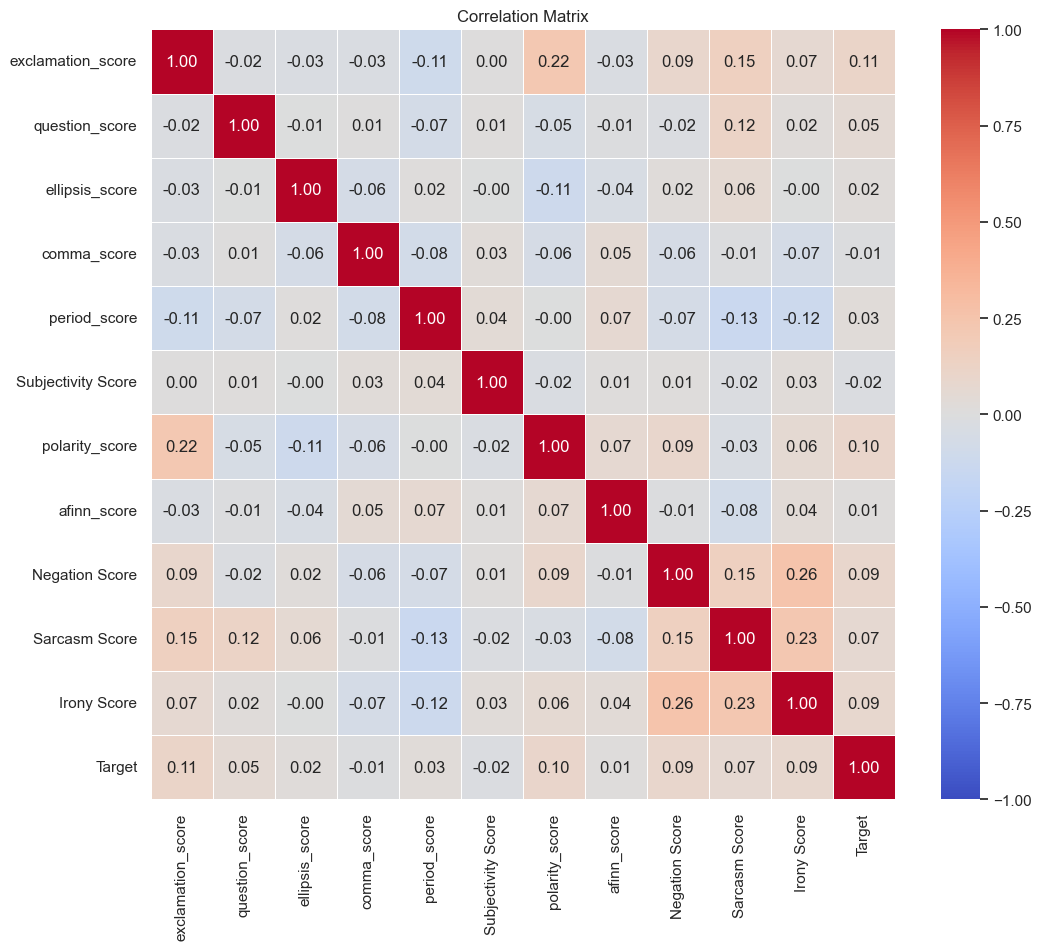

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = fuzzy_data.drop(columns=['Target'])  # Replace 'Target' with your actual target column name
y = fuzzy_data['Target']

# Use an SVM classifier with a linear kernel (or any other estimator of your choice)
model = SVC(kernel='linear')

# Create the RFE object, specifying the estimator and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=5)  # Adjust the number as needed

# Fit the RFE model on the data
rfe.fit(X, y)

# Get the ranking of the features, lower values indicate more important features
ranking = rfe.ranking_

# Create a DataFrame to easily view the results
rfe_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': ranking
}).sort_values(by='Ranking')

print(rfe_df)

               Feature  Ranking
0    exclamation_score        1
1       question_score        1
2       ellipsis_score        1
3          comma_score        1
5   Subjectivity Score        1
8       Negation Score        2
6       polarity_score        3
10         Irony Score        4
4         period_score        5
7          afinn_score        6
9        Sarcasm Score        7


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'target' is your dependent variable and the feature columns are independent variables
X = fuzzy_data.drop(columns=['Target'])  # Replace 'Target' with your actual target column name
y = fuzzy_data['Target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an SVM model with a linear kernel (suitable for RFE)
svm_model = SVC(kernel='linear')

# RFE for feature selection
rfe = RFE(estimator=svm_model, n_features_to_select=7)  # Select the top 5 features, adjust as needed
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = [feature for feature, rank in zip(fuzzy_data.columns, rfe.ranking_) if rank == 1]
print("Selected Features: ", selected_features)

# Transform the train and test data to only use selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the SVM model on the selected features
svm_model.fit(X_train_rfe, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_rfe)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with selected features: {accuracy}")

Selected Features:  ['exclamation_score', 'question_score', 'ellipsis_score', 'comma_score', 'Subjectivity Score', 'polarity_score', 'Negation Score']
Model accuracy with selected features: 0.21973094170403587
